# A brief demo of the disparity energy model

This notebook illustrates the ideas behind the disparity energy model, first described in its classical form by Ohzawa and colleagues (Ohzawa et al, 1990). 
The code is written in Julia (http://julialang.org/). This notebook has some interactive bits which won't work in the static form (i.e. when viewed in nbviewer). You can download this notebook and run it on your local machine (assuming that you can run IPython/Jupyter notebooks with the Julia profile). I will assume that you are running this on your local machine with all the interactive stuff working properly.

## Simple receptive fields

The receptive field is a fundamental concept in neuroscience. In short, a receptive field can be seen as a region of the input space which elicits a response in a given neuron (usually, this means that the neuron's firing rate is increased). In vision, the input space is the visual field. 

For instance, neurons in primary visual cortex (V1) respond strongly to edges in particular positions and orientations in the visual field (as shown by Hubel and Wiesel in the 60's). By examining the response of individual neurons to different positions and orientations, one can then characterize the respective receptive fields. The receptive field can therefore be interpreted as a filter (or map) that transforms an input into a neural response.

In V1, these receptive fields are often well described by Gabor functions. A Gabor is simply a periodic function tapered by a gaussian envelope. As a simple example, let's start by building a simple receptive field using a gabor function. As you can see by manipulating the phase slider, the shape of the receptive field is strongly influenced by the phase parameter.

  likely near /Users/NunoGoncalves/.julia/Interact/src/IJulia/setup.jl:153
  likely near /Users/NunoGoncalves/.julia/Interact/src/IJulia/setup.jl:157


Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"ϕ",0.0,-1.5707963267948966:0.19634954084936207:1.5707963267948966)

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"xo",0.0,-3.0:0.1:3.0)

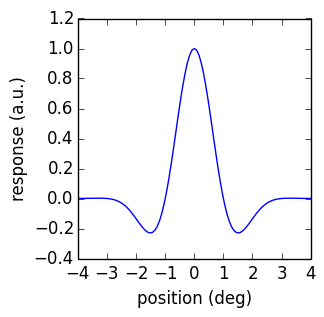

 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in require at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/NunoGoncalves/.julia/IJulia/src/execute_request.jl:177
 in eventloop at /Users/NunoGoncalves/.julia/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /Users/NunoGoncalves/.julia/In

In [1]:
# let's plot a 1-d Gabor
gabor(a::Float64, x::LinSpace, xo::Float64, sigma::Float64, f::Float64, phi::Float64) = a * exp(-((x-xo).^2)./(2*sigma^2)).*cos(2*pi*f*x-phi-2π*f*xo);
x = linspace(-4,4,101); # 1-d space (deg)

using Interact
using PyPlot

f = figure(figsize=(3,3))
@manipulate for ϕ=-π/2:π/16:π/2, xo=-3.0:0.1:3.0 
    withfig(f, clear=false) do
        # clear axes 
        cla() 
        # replot
        plot(x, gabor(1.0,x,xo,1.0,0.25,ϕ))
        xlabel("position (deg)")
        ylabel("response (a.u.)")
    end
end


When we talk about the position of oriented lines, then we need to represent the receptive field in two-dimensions. In that case, the receptive field can be represented as follows:

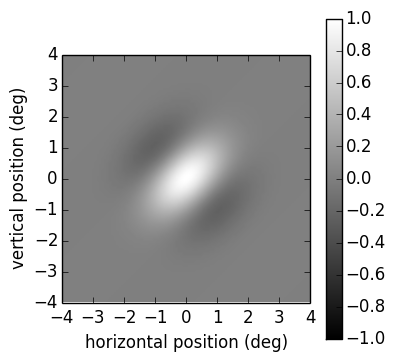

PyObject <matplotlib.text.Text object at 0x311b4eb10>

In [2]:
# the 2d-gabor parameters - play around with these and re-evaluate the cell to see the result
sigma, gamma, mu, sf, theta, phi = 1.0, 1.0, 0.0, 0.25, π/4, 0.0

xp(xi::Float64,yi::Float64,theta::Float64) = -xi*cos(theta) + yi*sin(theta)

G = [ exp(-(xi-mu).^2/(2.0*sigma^2)-gamma^2*(yi-mu).^2/(2.0*sigma^2)).*cos(2*π*sf*(xp(xi,yi,theta)-mu) - phi) for xi in linspace(-4,4,101), yi in linspace(-4,4,101)]

fig = figure(figsize=(4,4))
imshow(G, cmap="gray", clim=(-1,1), extent=(-4,4,-4,4), origin="lower")
colorbar()
ylabel("vertical position (deg)")
xlabel("horizontal position (deg)")

The response of a cell with this receptive field could then be *approximated* by applying this linear filter to the stimulus. This is the case for many cells in primary visual cortex, known as simple cells.

The next thing we need to know is that some neurons only seem to respond to stimulation of one eye (i.e. it is not possible to map a receptive field in the other eye), which are known as monocular neurons. Since they don't seem to care about what's happening in one eye, these neurons are unlikely to carry out any kind of binocular processing. So, let's forget about them and focus on neurons for which we can identify a receptive field in both eyes - binocular neurons.

## Building a disparity detector

Now, how can we capture displacement of the right and left-eye images? We need systematic differences between left and right receptive fields. With gabor models, you can introduce these differences via the position of the gabor or via the phase parameter. Let's illustrate this in 1-d first.

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"d",0.0,-1.0:0.0625:1.0)

Interact.Options{:Dropdown,ASCIIString}([Reactive.Input{ASCIIString}] position,"","position","position",Interact.OptionDict(Any["position","phase"],Dict{Any,Any}("phase"=>"phase","position"=>"position")),Any[],Any[])

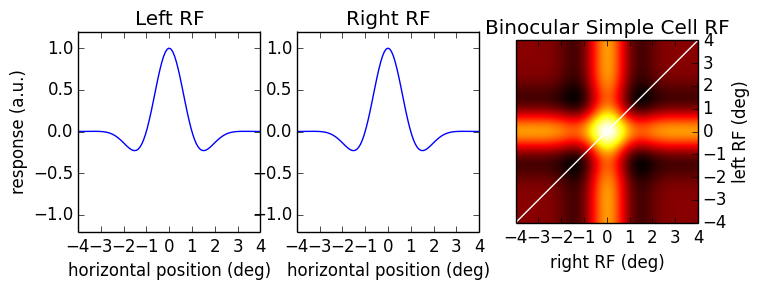

In [3]:
# let's define some parameters
a, xo, sd, sf, ϕ =1.0, 0.0, 1.0, 0.25, 0.0

f, axes = PyPlot.subplots(1, 3, sharey=false, figsize=(8, 2.5))
@manipulate for d=-1.0:1/16:1.0, shiftType in dropdown(["position","phase"]) # fun=[:pos => cos, :phase => sin]
    withfig(f, clear=false) do
        # clear axes 
        axes[1][:cla]()
        axes[2][:cla]()
        axes[3][:cla]()
        
        if shiftType == "position"
            dpos = d * maximum(x)
            dphase = 0
        else
            dpos = 0
            dphase = d * π/2
        end
        
        lRF = gabor(a,x,xo-dpos/2,sd,sf,ϕ)
        rRF = gabor(a,x,xo+dpos/2,sd,sf,ϕ+dphase)
        
        # replot 
        axes[1][:plot](x, lRF)
        axes[1][:set_title]("Left RF")
        axes[1][:set_xlabel]("horizontal position (deg)")
        axes[1][:set_ylabel]("response (a.u.)")
        axes[1][:set_ylim]([-1.2, 1.2])
        
        axes[2][:plot](x, rRF)
        axes[2][:set_title]("Right RF")
        axes[2][:set_xlabel]("horizontal position (deg)")
        axes[2][:set_ylim]([-1.2, 1.2])
        
        axes[3][:imshow](lRF .+ rRF', cmap="hot", extent=(-4,4,-4,4), origin="lower")  # binocular summation - this operation is called broadcasting
        axes[3][:autoscale](false)
        axes[3][:plot](-4:4, -4:4, color="w")
        axes[3][:set_title]("Binocular Simple Cell RF")
        axes[3][:set_xlabel]("right RF (deg)")
        axes[3][:set_ylabel]("left RF (deg)")
        axes[3][:yaxis][:tick_right]()
        axes[3][:yaxis][:set_label_position]("right")
    
    end
end


Above you will see the left and right receptive fields of a simple binocular cell (left and middle plots) and the respective binocular receptive field (right). This RF is obtained by binocular summation (i.e. simply by summing the response of the left and right RFs to the stimulus). The binocular RF simply illustrates the response of the cell (color-coded by a heatmap) as a function of the position of the stimulus in the left and right eyes. The white line represents the zero-disparity surface (i.e. all the points that fall in corresponding positions in the left and right retinae).

So, let's set the displacement `d` to 0, meaning that there will be no difference between the left and right RFs. In this case, you will see that the maximum response of the cell is elicited if the stimulus is positioned in corresponding positions of the left and right receptive fields (if `xo = 0`, then you'll see a white blob at [0,0]). If the stimulus falls on non-corresponding positions of the RFs, the cell won't respond that strongly (e.g. compare the response at [0,0] with that at [-2, 4]). So, the response of the cell varies with the disparity of the stimulus, which is good...ish. As you can see by the lack of diagonal structure in the RF, the cell will not respond well if the stimulus is presented in corresponding but off-center positions within the RF (e.g. [0.5,0.5]) - this means that the response of the simple cell is a function of simulus position within the RF. This can be demonstrated mathematically - Quian (1994) demonstrates very well this mathematical dependency and how to get rid of it.

The short story is that you can achieve position invariance (within the RF) with complex cells that effectively combine the output of two binocular simple cells whose receptive field are in quadrature. This entails applying a rectifying non-linearity to each simple cell (e.g. by squaring operation), and then sum the resulting outputs across simple cells. This is what we will do next.

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"d",0.0,-1.0:0.0625:1.0)

Interact.Options{:Dropdown,ASCIIString}([Reactive.Input{ASCIIString}] position,"","position","position",Interact.OptionDict(Any["position","phase"],Dict{Any,Any}("phase"=>"phase","position"=>"position")),Any[],Any[])

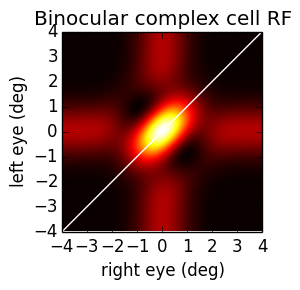

In [4]:
# let's define some parameters
a, xo, sd, sf, ϕ =1.0, 0.0, 1.0, 0.25, 0.0

f1 = figure(figsize=(8, 2.5))
@manipulate for d=-1.0:1/16:1.0, shiftType in dropdown(["position","phase"]) # fun=[:pos => cos, :phase => sin]
    withfig(f1, clear=false) do
        # clear axes 
        cla()
        
        if shiftType == "position"
            dpos = d * maximum(x)
            dphase = 0
        else
            dpos = 0
            dphase = d * π/2
        end
        
        # simple cell #1
        lRF = gabor(a,x,xo-dpos/2,sd,sf,ϕ)
        rRF = gabor(a,x,xo+dpos/2,sd,sf,ϕ+dphase)
        sRF1 = lRF .+ rRF';
        
        # simple cell #2
        lRF = gabor(a,x,xo-dpos/2,sd,sf,ϕ+π/2)
        rRF = gabor(a,x,xo+dpos/2,sd,sf,ϕ+π/2+dphase)
        sRF2 = lRF .+ rRF';
        
        # complex cell
        cRF = sRF1.^2 + sRF2.^2
        
        # plot 
        imshow(cRF, cmap="hot", extent=(-4,4,-4,4), origin="lower")
        autoscale(false)
        plot(-4:4, -4:4, color="w")
        title("Binocular complex cell RF")
        xlabel("right eye (deg)")
        ylabel("left eye (deg)")
        
    end
end

As we can now see, the receptive field has now an elongated diagonal structure - that means that the response to a particular disparity will be approximately constant within the receptive field. You can play around with the displacement `d` to see how the diagonal structure translates away from the zero-disparity line. By doing so, you are generating receptive fields of complex cells selective for different binocular disparities. To give a more intuition on how these cells respond to different positions in depth, we can rotate the plot and imagine that we are looking at a scene from a top view.

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"d",0.0,-1.0:0.0625:1.0)

Interact.Options{:Dropdown,ASCIIString}([Reactive.Input{ASCIIString}] position,"","position","position",Interact.OptionDict(Any["position","phase"],Dict{Any,Any}("phase"=>"phase","position"=>"position")),Any[],Any[])

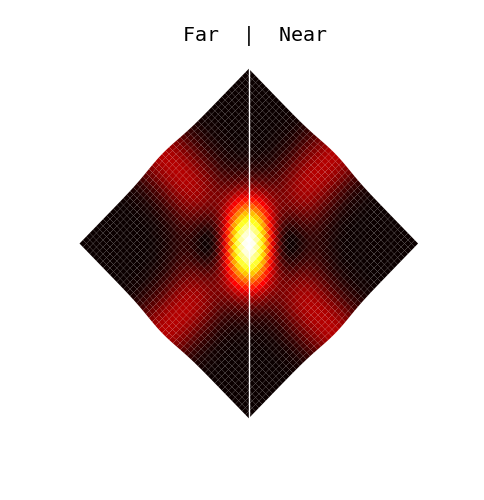

In [11]:
# rot = π/4;
rot = 0.0;

tm = [cos(rot) -sin(rot); sin(rot) cos(rot)]

n = [tm*[i;j] for i in linspace(-4,4,101), j in linspace(-4,4,101)]
nx = [n[i,j][1] for i = 1:101, j=1:101]
ny = [n[i,j][2] for i = 1:101, j=1:101]

# let's define some parameters
a, xo, sd, sf, ϕ =1.0, 0.0, 1.0, 0.25, 0.0

f3 = figure(figsize=(6,6))
@manipulate for d=-1.0:1/16:1.0, shiftType in dropdown(["position","phase"]) # fun=[:pos => cos, :phase => sin]
    withfig(f3, clear=false) do
        # clear axes 
        cla()
        
        if shiftType == "position"
            dpos = d * maximum(x)
            dphase = 0
        else
            dpos = 0
            dphase = d * π/2
        end
        
        # simple cell #1
        lRF = gabor(a,x,xo-dpos/2,sd,sf,ϕ)
        rRF = gabor(a,x,xo+dpos/2,sd,sf,ϕ+dphase)
        sRF1 = lRF .+ rRF';
        
        # simple cell #2
        lRF = gabor(a,x,xo-dpos/2,sd,sf,ϕ+π/2)
        rRF = gabor(a,x,xo+dpos/2,sd,sf,ϕ+π/2+dphase)
        sRF2 = lRF .+ rRF';
        
        # complex cell
        cRF = sRF1.^2 + sRF2.^2
        
        # plot
        plot_surface(nx,ny,cRF, cmap="hot", rstride=2, cstride=2, linewidth=0)
        ax = f3[:gca](projection="3d")
        ax[:view_init](90, 45)
        ax[:set_axis_off]()
        plot(-4:4, -4:4, color="w")
        title("  Far  |  Near", family="monospace")
        
        # subplot(1,2,2)
        # ylabel(" Left | Right ")
    end
end


Here we imagine that the observer is located on the right side and facing the plot. I hope that this example helps to understand how complex cells respond to different positions in depth. 
These are the basic principles behind the disparity energy model. I shall warn you that this demo is only introductory, and many developments have been made in the last two decades or so. However, if you understand the basic idea, then you should be able to go through many papers that analyse/challenge/extend the disparity energy model. 
